In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from itertools import chain
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm
%matplotlib inline

In [296]:
p_common = {"b2":0, 'd1':1,'d2':1,'K1':1,'K2':1,'mu':0.1, 'V':100}
p_neutral = {"a1": 1, "b1": 0, "a2":1, **p_common}
p_strong = {"a1": 1, "b1": 1, "a2":2, **p_common}
p_weak = {"a1": 2, "b1": -1, "a2":1, **p_common}

In [291]:
def get_birth_rates(state, a1, a2, b1, b2, d1, d2, K1, K2, mu, V):
    trait_step = state.shape[0]
    u_vals = np.linspace(0, 1, trait_step) # Liste des valeurs du trait u.
    N_per_u = np.sum(state, axis=1) / V # Nombre d'individus avec chaque valeur de u (pour calculer F1 et F2).
    
    A1_per_u = [a1 + b1*u for u in u_vals] # Valeur de A1 pour chaque valeur de u.
    F1 = (d1 * K1) / (d1 * K1 + np.sum([u * N * A1 for u, N, A1 in zip(u_vals, N_per_u, A1_per_u)]))
    
    A2_per_u = [a2 + b2*u for u in u_vals] # Valeur de A2 pour chaque valeur de u.
    F2 = (d2 * K2) / (d2 * K2 + np.sum([(1-u) * N * A2 for u, N, A2 in zip(u_vals, N_per_u, A2_per_u)]))
    
    beta_per_u = [u * A1 * F1 + (1-u) * A2 * F2 for u, A1, A2 in zip(u_vals, A1_per_u, A2_per_u)]
    
    #print(beta_per_u)
    
    return beta_per_u

In [303]:
def stochastic_simul(Tmax, nb_steps, state, birth_rates, mu, mutation_rate):
    """ Simulation stochastique avec l'algorithme de Gillespie.
    
    Paramètres :
        Tmax : temps final de la simulation.
        nb_steps : nombre d'étapes.
        state : np.ndarray de forme (trait_step, trait_step) représentant le nombre d'individus
                pour chaque couple (u, a) (u ligne, a colonne)
        get_birth_rates : fonction retournant le birth rate pour chaque u en fonction de l'état
        mu : taux de mortalité (indépendant des traits)
        
    """
    
    trait_step = state.shape[0] # combien de valeurs du trait on utilise
    dt = Tmax/nb_steps
    
    trajectory = np.zeros((nb_steps, trait_step, trait_step), dtype=int) # On sauvegarde l'état initial.
    
    for t in range(nb_steps):
        #print('étape {}, state:\n{}'.format(t, state))
        # on calcule tous les taux
        birth_rate_per_u = birth_rates(state)
        
        new_state = np.zeros((trait_step, trait_step))
        
        for u_i in range(trait_step):
            for a_i in range(trait_step):
                if state[u_i][a_i] > 0:
                    nb_repros = np.random.poisson(state[u_i][a_i]*birth_rate_per_u[u_i]*dt)
                    nb_morts = np.random.poisson(state[u_i][a_i]*mu*dt)
                    # on oublie l'affinité pour l'instant
                    for i in range(nb_repros):
                        mute_u = np.random.binomial(1, mutation_rate)
                        mute_a = np.random.binomial(1, mutation_rate)
                        augmente_u = 0
                        augmente_a = 0
                        if mute_u:
                            augmente_u = np.random.binomial(1, 0.5) * 2 - 1
                        if mute_a:
                            augmente_a = np.random.binomial(1, 0.5) * 2 - 1
                        
                        nouv_u = min(max(u_i + augmente_u, 0), trait_step-1)
                        nouv_a = min(max(a_i + augmente_a, 0), trait_step-1)
                        
                        new_state[nouv_u][nouv_a] += 1
                        
                    new_state[u_i][a_i] = max(state[u_i][a_i] + new_state[u_i][a_i] - nb_morts, 0)
                        
        trajectory[t, :, :] = state[:, :]
        state = new_state
        
    return trajectory

In [324]:
state = np.zeros((20, 20))
state[19, 10] = 200

In [325]:
traj = stochastic_simul(2000, 20000, state, partial(get_birth_rates, **p_strong), p_strong["mu"], 0.1)

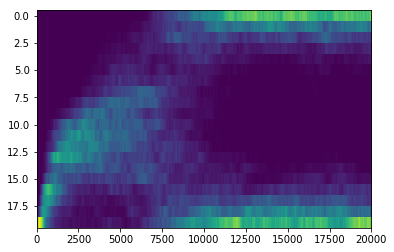

In [326]:
plt.imshow(np.sum(traj, axis = 2).transpose(), aspect='auto') # on somme sur a pour avoir (u, t)

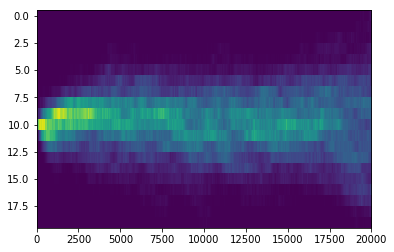

In [327]:
plt.imshow(np.sum(traj, axis = 1).transpose(), aspect='auto') # on somme sur u pour avoir (a, t)